This is just an attempt to forecast weather. I'll be using some machine-learning techniques, most likely lstm/RNN networks. The weather data is on 20 some US cities, 8 israeli cities and one in canada. Got it on kaggle, dubbed "historical hourly weather data"

In [28]:
import numpy as np 
import tensorflow as tf 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline

Loading data, it's now in an hourly format with a fair share of vacancies that pandas can fill with the "ffill" method

In [29]:
datapath = "/home/joe/Documents/tensor/weather/historical-hourly-weather-data/"
names=['city_attributes.csv','humidity.csv','pressure.csv','temperature.csv','weather_description.csv','wind_direction.csv','wind_speed.csv']
data = []
for i in range(1,7):
    print i
    data_i = pd.read_csv(datapath+names[i], index_col='datetime', parse_dates=['datetime'])
    data_i = data_i.iloc[1:]
    data_i = data_i.fillna(method='ffill')
    data_i = data_i.fillna(method='bfill')
    data.append(data_i)

1
2
3
4
5
6


Suitable variable names, delete unnecessary data

In [30]:
#create variables
humidity = data[0] #floats , no idea 
pressure = data[1] #floats kPa i think
temperature = data[2] #floats kelvin
weather = data[3]   #string
wind_dir = data[4]  #degrees [0,360]
wind_vel = data[5]
if 'data' in globals(): #if data hasn't already been deleted for memory purposes
    del(data)
    del(data_i)

Choose a city?

In [31]:
cityname = "Vancouver"
if len(cityname) > 2:
    humidity = humidity[cityname].asfreq('D')
    pressure = pressure[cityname].asfreq('D')
    temperature = temperature[cityname].asfreq('D')
    weather = weather[cityname].asfreq('D')
    wind_dir = wind_dir[cityname].asfreq('D')
    wind_vel = wind_vel[cityname].asfreq('D')

Plot?

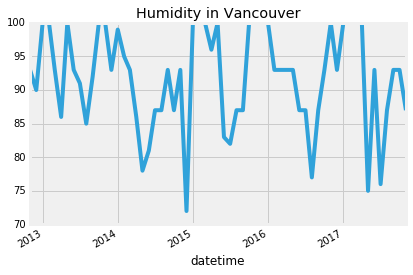

In [32]:
''' #Useful operations
#print humidity.tail()
#print humidity.resample('H').shape
'''
humidity.asfreq('M').plot()
#humidity.rolling('30D').mean().plot()
plt.title("Humidity in %s"%cityname)
plt.show()


Can't use previous plot functions, or scripts, after this point, here starts the machinelearning I hope

In [33]:
humidity_a = humidity.as_matrix() #numpy array from here
pressure_a = pressure.as_matrix()
temperature_a = temperature.as_matrix()
weather_a = weather.as_matrix()
wind_dir_a = wind_dir.as_matrix()
wind_vel_a = wind_vel.as_matrix()

In [34]:
weather_types = dict() #weather to id
weather_frequency = dict() #weather to frequency
j = 0
for i in range(len(weather_a)):
    
    if weather_a[i] not in weather_types:
        weather_frequency[weather_a[i]] = 0
        weather_types[weather_a[i]] = j 
        j+=1
    weather_frequency[weather_a[i]] += 1
    weather_a[i] = weather_types[weather_a[i]]
for i in range(50,55):
    print pressure_a[i], temperature_a[i], wind_dir_a[i], wind_vel_a[i]

997.0 281.84 70.0 1.0
997.0 280.07 80.0 2.0
997.0 278.06 40.0 1.0
1001.0 277.8 80.0 2.0
1013.0 279.83 60.0 3.0


Weather types will now be ranked by frequency. We then remove rare weather

In [35]:
sorted_weather = sorted( zip(weather_frequency.values(),weather_types.values()))
print sorted_weather

[(1, 9), (1, 18), (1, 20), (2, 13), (2, 19), (2, 21), (3, 17), (4, 15), (5, 14), (9, 16), (19, 11), (38, 12), (51, 3), (68, 8), (70, 7), (105, 6), (149, 10), (163, 0), (176, 1), (237, 5), (261, 4), (519, 2)]


Here we pinpoint which indices in the dataset that belong to the most frequent weather types. (and redefine the dataset so that only the data belonging to typical weather remains. We also normalize the data.

In [82]:
threshold = 50 #number of occurences of a weather we want to forecast
ids_to_keep = []
for n,ID in sorted_weather:
    if n > threshold:
        ids_to_keep.append(ID)
print "These are the ids of weather we want to keep: ", ids_to_keep 
print "The amount of initial data points: ", len(weather_a)
indices_we_want = []
for i in range(len(weather_a)):
    if weather_a[i] in ids_to_keep:
        indices_we_want.append(i)


print "The amount of data after removing rare weather: ", len(indices_we_want)
weather_a2 = weather_a[indices_we_want]
humidity_a2 = humidity_a[indices_we_want]/np.linalg.norm(humidity_a[indices_we_want]) #numpy array from here
pressure_a2 = pressure_a[indices_we_want]/np.linalg.norm(pressure_a[indices_we_want])
temperature_a2 = temperature_a[indices_we_want]/np.linalg.norm(temperature_a[indices_we_want])
wind_dir_a2 = wind_dir_a[indices_we_want]* np.pi / 180.
wind_vel_a2 = wind_vel_a[indices_we_want]/np.linalg.norm(wind_vel_a[indices_we_want])
n_weather = len(ids_to_keep)
weather_one_hot_o = (np.arange(n_weather) == weather_a2[:,np.newaxis])*1
print weather_one_hot_o.shape
print weather_one_hot_o[1] #how the one-hots look, this probably means "broken clouds"

These are the ids of weather we want to keep:  [3, 8, 7, 6, 10, 0, 1, 5, 4, 2]
The amount of initial data points:  1886
The amount of data after removing rare weather:  1799
(1799, 10)
[0 1 0 0 0 0 0 0 0 0]


2 degrees and 355 are not too different when using trig.functions. However, we need both sine and cosine, unless we can't
differentiate between north and south / east n west.

In [83]:
wind_dir_sin = np.sin(wind_dir_a2)/np.linalg.norm(np.sin(wind_dir_a2))
wind_dir_cos = np.cos(wind_dir_a2)/np.linalg.norm(np.cos(wind_dir_a2)) 
print weather_a2.dtype
print humidity_a2.dtype
print pressure_a2.dtype
print temperature_a2.dtype
print wind_dir_a2.dtype
print wind_vel_a2.dtype
weather_a2 = weather_a2.astype(np.float32)
humidity_a2 = humidity_a2.astype(np.float32)
pressure_a2 = pressure_a2.astype(np.float32)
temperature_a2 = temperature_a2.astype(np.float32)
wind_dir_a2 = wind_dir_a2.astype(np.float32)
wind_vel_a2 = wind_vel_a2.astype(np.float32)
print weather_a2.dtype
print humidity_a2.dtype
print pressure_a2.dtype
print temperature_a2.dtype
print wind_dir_a2.dtype
print wind_vel_a2.dtype

object
float64
float64
float64
float64
float64
float32
float32
float32
float32
float32
float32


The data is now consisting of around 1800 daily measurements. I'm thinking of designing an lstm-based RNN in such a way that the three precursing days predict the weather on the fourth.

In [85]:
data = np.stack((weather_a2,humidity_a2,pressure_a2,temperature_a2,wind_dir_sin,wind_dir_cos,wind_vel_a2)).T
N_days = 3 #number of days to use before prediction day
#digitalization of weather description is simply its id, normalized then standardized
#it's the first of the 7 columns that now exist within "data"

meen = np.mean(data,axis=0)
std = np.std(data,axis=0)
data = (data-meen)/std
test_cursor = data.shape[0]-data.shape[0]/4
test_data = data[test_cursor:].astype(np.float32)
#test_data=  test_data.as_type(np.float32)
test_labels = weather_one_hot_o[test_cursor:]
data = data[:test_cursor]
weather_one_hot=weather_one_hot_o[:test_cursor]
classes = data.shape[-1]
n_labels = weather_one_hot.shape[-1]
print test_labels.shape
print data.shape
print weather_one_hot.shape

def accuracy(preds,labs):
    return np.mean(np.argmax(preds,axis=1)==np.argmax(labs,axis=1))
batch_size = 32

(449, 10)
(1350, 7)
(1350, 10)


In [86]:
def batchgen(batch,batch_label,size):
    x = []
    y = np.zeros((size,n_labels))
    for i in range(N_days):
        x.append(batch[i:(i+size)])
    y = batch_label
    return x,y
def batchgen2():
    x = []
    y = np.zeros((batch_size,n_labels))
    indices = np.random.choice(np.arange(len(data)-N_days-2),(N_days,batch_size),replace=False)
    for i in range(N_days-1):
        indices[i+1,:] = indices[i,:]+1
        x.append(data[indices[i]])
    x.append(data[indices[i+1]])
    y = weather_one_hot[indices[-1]+1]
    return x,y

In [87]:
num_nodes = 49*2 #since there're seven input nodes, 7 squares seems like a fitting number of nodes
ix = tf.Variable(tf.truncated_normal([classes, num_nodes], -0.1, 0.1))
ih = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
ib = tf.Variable(tf.zeros(num_nodes))
fx = tf.Variable(tf.truncated_normal([classes, num_nodes], -0.1, 0.1))
fh = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
fb = tf.Variable(tf.zeros(num_nodes))
ox = tf.Variable(tf.truncated_normal([classes, num_nodes], -0.1, 0.1))
oh = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
ob = tf.Variable(tf.zeros(num_nodes))
cx = tf.Variable(tf.truncated_normal([classes, num_nodes], -0.1, 0.1))
ch = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
cb = tf.Variable(tf.zeros(num_nodes))

saved_h = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False) #h_t-1
saved_cell = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False) #c_t-1
w = tf.Variable(tf.truncated_normal([num_nodes, n_labels], -0.1, 0.1))
b = tf.Variable(tf.zeros([n_labels]))

def lstm(x,h,cell):
    input_gate = tf.sigmoid(tf.matmul(x, ix) + tf.matmul(h, ih) + ib)
    forget_gate = tf.sigmoid(tf.matmul(x, fx) + tf.matmul(h, fh) + fb)
    update = tf.matmul(x, cx) + tf.matmul(h, ch) + cb
    cell = forget_gate * cell + input_gate * tf.tanh(update)
    h = tf.sigmoid(tf.matmul(x, ox) + tf.matmul(h, oh) + ob)
    return h * tf.tanh(cell), cell
x_train = list()
for i in range(N_days):
    x_train.append(tf.placeholder(tf.float32,shape=[batch_size,classes]))
y_train = tf.placeholder(tf.float32,shape=[batch_size,n_labels])

# Unrolled LSTM loop. #forward propogating
h = saved_h   #think more about these
cell = saved_cell
for i in x_train:
    h, cell = lstm(i, h, cell)
# State saving across unrollings.

test_n = test_data.shape[0]
input_size = test_n/N_days
x_test = list()
#x_test = tf.constant(test_data)

saved_h_test = tf.Variable(tf.zeros([input_size, num_nodes]), trainable=False) #h_t-1
saved_cell_test = tf.Variable(tf.zeros([input_size, num_nodes]), trainable=False) #c_t-1

for i in range(N_days):
    x_test.append(tf.placeholder(tf.float32,shape=[input_size,classes]))
y_test = tf.placeholder(tf.float32,shape=[input_size,n_labels])


h_test = saved_h_test
cell_test = saved_cell_test
for i in range(N_days):
    h_test, cell_test = lstm(x_test[i],h_test,cell_test)

with tf.control_dependencies([saved_h.assign(h),
                              saved_cell.assign(cell)]):
                              
    logits = tf.matmul(h,w)+b
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits_v2(
            labels= y_train, logits = logits))
with tf.control_dependencies([saved_h_test.assign(h_test),
                              saved_cell_test.assign(cell_test)]):
    test_preds = tf.nn.softmax(tf.matmul(h_test, w)+b)

learning_rate = tf.Variable(1.0)
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)


In [93]:
epochs = 100
decay = learning_rate.assign(tf.multiply(0.4,learning_rate))
days = int(data.shape[0])
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for e in range(epochs):
        for cursor in range(0,days-batch_size-N_days-2,batch_size):
            batchx = data[cursor:(cursor+batch_size+N_days+1)] #weather data (batch + 4)
            batchy = weather_one_hot[cursor+N_days+1:(cursor+batch_size+N_days+1)] #weather targets (batch)
            #x,y = batchgen(batchx,batchy,batch_size) #data structured into batches
            x,y = batchgen2()
            feed_dict = dict()
            for i in range(N_days):
                feed_dict[x_train[i]] = x[i]
            feed_dict[y_train]=y
            _, l, preds = sess.run([optimizer,loss,logits],feed_dict=feed_dict)
        #if cursor %batch_size*10 ==0:
        if e % 5 == 0:
            sess.run(decay)
            #print sess.run(learning_rate), 'learning rate'
            print accuracy(preds,y), "batch accuracy"

    test = []
    for i in range(0,test_n-input_size-N_days-2,input_size):
        testx = test_data[i:(i+input_size+N_days+1)]
        testy = test_labels[i+N_days+1:(i+input_size+N_days+1)]
        xt,yt = batchgen(testx,testy,input_size)
        feedy_dict = dict()
        for j in range(N_days):
            feedy_dict[x_test[j]] = xt[j]
        feedy_dict[y_test] = yt
        test.append(accuracy(sess.run(test_preds,feed_dict=feedy_dict),yt))
    print np.mean(test), 'wat'


0.34375 batch accuracy
0.34375 batch accuracy
0.34375 batch accuracy
0.40625 batch accuracy
0.28125 batch accuracy
0.34375 batch accuracy
0.25 batch accuracy
0.125 batch accuracy
0.375 batch accuracy
0.25 batch accuracy
0.21875 batch accuracy
0.3125 batch accuracy
0.375 batch accuracy
0.3125 batch accuracy
0.4375 batch accuracy
0.3125 batch accuracy
0.15625 batch accuracy
0.28125 batch accuracy
0.46875 batch accuracy
0.15625 batch accuracy
0.27181208053691275 wat
